# 4. Shortlist Quantitative

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Dans cette partie, on sélectionne un certain nombre de comptes intéressants sur la base de critères quantitatifs. On crée un tableau qui contient différentes valeurs pour différents indicateurs et on retient une petite liste d'influenceurs sur la base de ces critères. 

Plus précisément, on calcule, sur la base des posts les plus récents sur leur page, un indice d'authenticité et un indice d'intéraction. On réinjecte également la centralité de vecteur propre et le PageRank qui nous ont servi à l'étape précédente. 

## Extraction et préparation des données

In [2]:
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import urllib
import bs4
from urllib import request
import pandas as pd
import re
import time
from numpy import arange, repeat, concatenate
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer #pip install vaderSentiment
from collections import defaultdict

In [3]:
# Importer le fichier du notebook précédent (central_points) 

with open("central_points.txt",'r') as r:
    init_file=list(r)
    init_file = init_file[0]
    users=init_file.split('\t')
    users.remove(users[users.index('')])
len(users)

2839

In [4]:
def scrape_user(username):
    output=[]
    output.append(username)
    #aller sur la page
    link = "https://www.instagram.com/%s/"%username
    request_text = request.urlopen(link).read()
    page = bs4.BeautifulSoup(request_text,'html.parser')
    scripts=page.findAll("script"
                        )
    #récupérer le bout de graphql
    char="graphql"
    to_be_sorted=""
    for z in range(len(scripts)):
        tryout=str(scripts[z])
        if char in tryout:
            to_be_sorted=to_be_sorted+tryout
    #récupérer le nombre de followers
    to_be_sorted_bis = to_be_sorted.replace(",", "")        
    
    pos1 = to_be_sorted_bis.find('edge_followed_by":{"count":')
    follower = '' 
    i = 0
    while to_be_sorted_bis[pos1+27+i] != '}' and i<1000:
        follower = follower + to_be_sorted_bis[pos1+27+i]
        i = i+1
    output.append(follower)
    
    #récupérer
    
    # ce qu'on peut sortir: 
    ###la biographie :
    biography=to_be_sorted[to_be_sorted.find('{"biography":"')+14:to_be_sorted.find("blocked_by_viewer")-3]
    output.append(biography)

    ###is_business_account / 
    busi=to_be_sorted[to_be_sorted.find("is_business_account"):to_be_sorted.find("is_business_account")+30]
    if 'true' in busi:
        business=True
    else:
        business=False
    output.append(business)
    
    ###business_category_name 
    business_category=to_be_sorted[to_be_sorted.find("business_category_name")+25:to_be_sorted.find("business_email")-3]
    output.append(business_category)

    ###is_verified
    verif=to_be_sorted[to_be_sorted.find("is_verified"):to_be_sorted.find("is_verified")+30]
    if 'true' in verif:
        is_verified=True
    else:
        is_verified=False
        
    output.append(is_verified)
    
    return output

In [5]:
def scrape_posts(username):
    
    output=[]
    
    #aller sur la page
    link = "https://www.instagram.com/%s/"%username
    request_text = request.urlopen(link).read()
    page = bs4.BeautifulSoup(request_text,'html.parser')
    scripts=page.findAll("script")
    #récupérer le bout de graphql
    char="graphql"
    to_be_sorted=""
    for z in range(len(scripts)):
        tryout=str(scripts[z])
        if char in tryout:
            to_be_sorted=to_be_sorted+tryout
            
    #analyse du graphql à proprement parler
    to_be_sorted=to_be_sorted[to_be_sorted.find("graphql"):]
    #par post
    
    posts=to_be_sorted.split("__typename")
    posts.remove(posts[0])
    for i in range(len(posts)):
        intermediate=[]
        intermediate.append(username)
        post_en_cours=posts[i]

        #Caption
        caption=post_en_cours[post_en_cours.find("edge_media_to_caption")+50:post_en_cours.find("shortcode")-7]
        intermediate.append(caption)
        
        #si le post est une vidéo ou non
        video=post_en_cours[post_en_cours.find("is_video"):post_en_cours.find("is_video")+20]
        if 'true' in video:
            is_video=True
        else:
            is_video=False
        intermediate.append(is_video)
        
        # commentaires
        comments=int(post_en_cours[post_en_cours.find("edge_media_to_comment")+32:post_en_cours.find("comments_disabled")-3])
        intermediate.append(comments)
        #nombre de likes
        likes=int(post_en_cours[post_en_cours.find("edge_liked_by")+24:post_en_cours.find("edge_media_preview_like")-3])
        intermediate.append(likes)
        # date de l'upload
        taken_at=int(post_en_cours[post_en_cours.find("taken_at_timestamp")+20:post_en_cours.find("dimensions")-2])
        time2=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(taken_at))
        intermediate.append(time2)
        
    
        output.append(intermediate)
        
    return output

In [6]:
# On le fait en plusieurs étapes vu qu'on se fait bannir à chaque fois
L=[]

In [43]:
users2=users[users.index(L[-1][0])+1:]  #Créer une liste d'utilisateurs pour reprendre où on en était
len(users2)

43

In [44]:
i=0
#for usr in users:    #A la première itération
for usr in users2:   #Aux itérations suivantes - commenter au dessus, décommenter ici
    i+=1
    if i%20==0:
        print('current user :', usr)
#        print('progress = %8.2f'% (users.index(usr)/len(users)*100),'%')
        print('progress = %8.2f'% (users2.index(usr)/len(users2)*100),'%')
    L.append(scrape_user(usr))

current user : withwoodspoon
progress =    44.19 %
current user : originesparfums
progress =    90.70 %


In [42]:
print(len(L))   #Doit sommer à len(users), sinon il y a une couille qque part (modulo les 404) 
print('***')  

2793
***


In [45]:
Users = []
for i in range(len(L)):
    z = L[i][0]
    Users.append(z)
Users = pd.Series(Users)

In [46]:
followers = []
for i in range(len(L)):
    z = L[i][1]
    followers.append(z)
followers = pd.Series(followers)

In [47]:
biography = []
for i in range(len(L)):
    z = L[i][2]
    biography.append(z)
biography = pd.Series(biography)

In [48]:
business_account=[]
for i in range(len(L)):
    z = L[i][3]
    business_account.append(z)
business_account = pd.Series(business_account)

In [49]:
has_joined_recently=[]
for i in range(len(L)):
    z = L[i][4]
    has_joined_recently.append(z)
has_joined_recently = pd.Series(has_joined_recently)

In [50]:
is_verified=[]
for i in range(len(L)):
    z = L[i][5]
    is_verified.append(z)
is_verified = pd.Series(is_verified)

In [51]:
df = pd.DataFrame()
df['user']=Users.values
df['followers']=followers.values
df['biography']=biography.values
df['business_account']=business_account.values
df['has_joined_recently']='Irrelevant'
df['is_verified']=is_verified.values

In [52]:
df.to_csv("users_dataframe.csv", index = True, header=True)

df.head()

,user,followers,biography,business_account,has_joined_recently,is_verified
0,bestofvanity,9286,\u2693\ufe0f Bretonne expatri\u00e9e \ud83c\ud...,True,Irrelevant,False
1,deedeeparis,68181,\u2716\ufe0fParisian journalist \u0026 lifesty...,True,Irrelevant,False
2,saeve_france,10464,1\u00e8re marque de cosm\u00e9tiques transmett...,True,Irrelevant,False
3,lilibarbery,40337,Founder of wellness \u0026 lifestyle blog http...,True,Irrelevant,True
4,misswofficiel,2808,Marque fran\u00e7aise de maquillage certifi\u0...,True,Irrelevant,False


In [59]:
publications = []  # Idem en plusieurs fois pour contourner les expulsions

In [153]:
users2=users[users.index(last_user)+1:]  #Créer une liste d'utilisateurs pour reprendre où on en était
len(users2)

116

In [154]:
i=0

#for usr in users:
for usr in users2: #aux itérations suivantes
    
    i+=1
    if i%20==0:
        print('current user :', usr)
#        print('progress = %8.2f'% (users.index(usr)/len(users)*100),'%')
        print('progress = %8.2f'% (users2.index(usr)/len(users2)*100),'%')
    w = scrape_posts(usr)
    for j in range(len(w)):
        
        publications.append(w[j])
    
    last_user=usr

current user : bagheerasoy
progress =    16.38 %
current user : poiretcactus
progress =    33.62 %
current user : lifeasbeck
progress =    50.86 %
current user : cassandralaunay__
progress =    68.10 %
current user : mixtiles
progress =    85.34 %


In [155]:
print('Current start index : ',users.index(last_user), '-- for user', last_user)
print('***')

Current start index :  2838 -- for user karinejeff
***


In [156]:
user=[]
caption=[]
video=[]
nb_com=[]
nb_likes=[]
date=[]
for i in range(len(publications)):
    for j in range(len(publications[i])):
        if j == 0:
            user.append(publications[i][j])
        if j == 1:
            caption.append(publications[i][j])
        if j == 2:
            video.append(publications[i][j])
        if j == 3:
            nb_com.append(publications[i][j])
        if j == 4:
            nb_likes.append(publications[i][j])
        if j == 5:
            date.append(publications[i][j])
user=pd.Series(user)
caption=pd.Series(caption)
video=pd.Series(video)
nb_com=pd.Series(nb_com)
nb_likes=pd.Series(nb_likes)
date=pd.Series(date)

In [157]:
df0=pd.DataFrame()
df0['users']=user.values
df0['caption']=caption.values
df0['video']=video.values
df0['nb_com']=nb_com.values
df0['nb_likes']=nb_likes.values
df0['date']=date.values

In [158]:
p=[]
for user in users:
    z = arange(len(df0[df0.users==user]))
    p = concatenate((p,z), axis = 0)    

In [159]:
post = pd.Series(p)
df0['post']=post.values

In [160]:
arrays = [df0.loc[:,'users'],df0.loc[:,'post']]
index = pd.MultiIndex.from_arrays(arrays, names=('users', 'post'))
df_ = pd.DataFrame({'caption' : caption.values,'video' : video.values,'nb_com' : nb_com.values,'nb_likes' : nb_likes.values,'date' : date.values},
                    index=index)

In [161]:
df_.to_csv('posts_dataframe.csv',index=True,header = True)

df_.head()

caption  video  \
users        post                                                             
bestofvanity 0.0   \ud83c\uddee\ud83c\uddf9 Si vous souhaitez vou...  False   
             1.0   L\u2019autre soir on a parl\u00e9 d\u2019Angle...  False   
             2.0   Sur la C\u00f4te d\u2019Azur, il n\u2019y a pa...  False   
             3.0   \ud83c\udf3f Les jolies petites plantes des re...  False   
             4.0   \ud83c\udf74Qui vient d\u00eener ce soir ?\nPe...  False   

                   nb_com  nb_likes                 date  
users        post                                         
bestofvanity 0.0        6       385  2019-04-30 20:11:52  
             1.0       11       313  2019-04-25 10:01:55  
             2.0        9       402  2019-04-24 17:51:36  
             3.0       10       476  2019-04-14 13:58:29  
             4.0        9       263  2019-04-13 20:20:01

## Construction d'indices

### Taux d'engagement 

#### Correction exponentielle

On commence avec un exemple pour un utilisateur de l'effet de la correction par des poids exponentiels du nombre de commentaires pour tenir compte du fait que les posts les plus récents n'ont pas eu le temps d'avoir le même impact sur la communauté que les posts les plus anciens. 

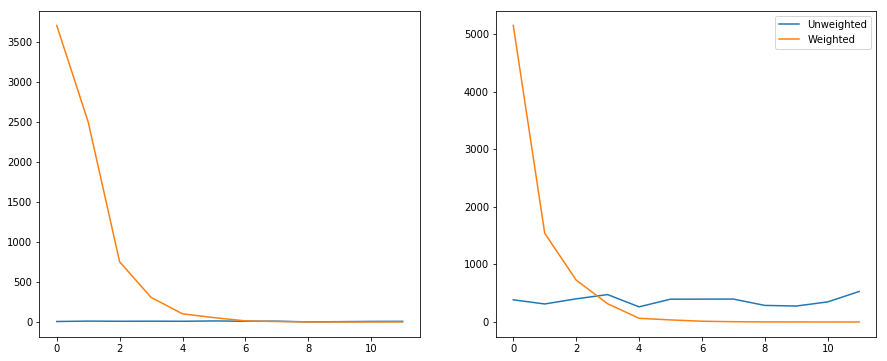

In [163]:
import matplotlib.pyplot as plt
import math

# For the comments

date_ranks=[]
for j in range(len(list(df_['date']['bestofvanity']))):
    date_ranks.append((j,df_['date']['bestofvanity'][j]))

date_ranks.sort(key=lambda r: r[1])
date_ranks.reverse()
date_ranks

com_values=[df_['nb_com']['bestofvanity'][date_ranks[i][0]] for i in range(len(date_ranks))]


#Generate and use weights
x= [k for k in range(len(list(df_['nb_com']['bestofvanity'])))]  #list to change
exp_x = [math.exp(i) for i in x]
w_exp=[(i/sum(com_values)) for i in exp_x]
w_exp.reverse()
wcom_val=[i*j for (i,j) in zip(com_values,w_exp)]


likes_values=[df_['nb_likes']['bestofvanity'][date_ranks[i][0]] for i in range(len(date_ranks))]


#Weights
w_exp2=[(i/sum(likes_values)) for i in exp_x]
w_exp2.reverse()
wlikes_val=[i*j for (i,j) in zip(likes_values,w_exp2)]


#Plotting figures

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(x,com_values)
ax1.plot(x,wcom_val)


ax2.plot(x,likes_values)
ax2.plot(x,wlikes_val)

plt.gca().legend(('Unweighted','Weighted'))

plt.show()


#### Calcul des taux d'engagement

In [164]:
import datetime

# On passe aux calculs de moyenne à proprement parler

users_w_info=list(df0['users'])
users_w_info=list(dict.fromkeys(users_w_info))

averages={}

for usr in users_w_info:
    
    date_ranks=[]
    dates=[]
    
    try:
        for j in range(len(list(df_['date'][usr]))):
            date_ranks.append((j,df_['date'][usr][j]))
            dates.append(df_['date'][usr][j])

        date_ranks.sort(key=lambda r: r[1])
        date_ranks.reverse()
    
        #On prend en compte la durée entre le plus ancien et le plus récent des posts
    
        dates=[datetime.datetime.strptime(date_initial, '%Y-%m-%d %H:%M:%S') for date_initial in dates]
        periode=str(max(dates)-min(dates))
        periode=periode[:periode.find(' day')]
    
        try: periode=int(periode)
        except: periode=1
    
        com_values=[df_['nb_com'][usr][date_ranks[i][0]] for i in range(len(date_ranks))]


        #Generate and use weights
        x= [k for k in range(len(list(df_['nb_com'][usr])))]  #list to change
        exp_x = [math.exp(i) for i in x]
        w_exp=[(i/max(1,sum(com_values))) for i in exp_x]
        w_exp.reverse()
        
        w_exp=[1 for k in range(len(list(df_['nb_com'][usr])))]    #Commenter pour remettre les poids exponentiels
        
        wcom_val=[i*j for (i,j) in zip(com_values,w_exp)]


        likes_values=[df_['nb_likes'][usr][date_ranks[i][0]] for i in range(len(date_ranks))]


    #Weights
        w_exp2=[(i/max(1,sum(likes_values))) for i in exp_x]
        w_exp2.reverse()
        wlikes_val=[i*j for (i,j) in zip(likes_values,w_exp2)]


        wavg_com=sum(wcom_val)/max(1,len(list(df_['date'][usr])))
        wavg_likes=sum(wlikes_val)/max(1,len(list(df_['date'][usr])))
    
        averages[usr]=[(wavg_com,wavg_likes),periode]
        
    except:
        averages[usr]=[(0,0),0]

In [165]:
followers=[]
for j in range(len(list(df['user']))):
    followers.append((df['user'][j],df['followers'][j]))
    
len(averages) , len(followers)  #Comparer avec le nombre total d'utilisateurs qu'on avait au début

(2802, 2836)

In [166]:
engagement_ratio={}
users_list=list(averages.keys())

for i in range(len(followers)):
    
    usr=followers[i][0]
    
    if usr in users_list:
        

        
        follow=float(followers[i][1])
        
        periode=int(averages[usr][1])
        
        likes=float(averages[usr][0][1])
        comment=float(averages[usr][0][0])
    
        values=(comment/(periode*follow)*100,likes/(periode*follow)*100)

    else:
        values=(0,0)
        
    engagement_ratio[usr]=values
    
# On supprimer les observations nulles 
engagement_ratio={k:v for k,v in engagement_ratio.items() if v!=(0,0)}

len(engagement_ratio)

2801

In [167]:
# On récupère la liste des utilisateurs à jour 
users=list(engagement_ratio.keys())
len(users)

2801

### Indice d'authenticité

In [170]:
def normalize_values(d):
    """
    Return dictionary with normalized values (0 to 1).
    Args:
        d (dict): Dictionary with user ids and raw scores.
    Returns:
        d_norm (dict): Dictionary with user ids and normalized scores.
    """
    minimum = min(d.items(), key= lambda x: x[1])[1]
    maximum = max(d.items(), key= lambda x: x[1])[1]

    d_norm = {}
    for user_id in d:
        d_norm[user_id] = (d[user_id] - minimum) / (maximum - minimum)

    return d_norm

def calc_authenticity_score(users, df):
    """
    Calculate and sort by authenticity scores for reduced graph based
        on compound sentiment analysis score (higher scores for more negative posts).
    Args:
        df: pandas.Dataframe
        users : list of users
    Returns:
        authenticity_score
    """
    analyzer = SentimentIntensityAnalyzer()
    
    caption_sentiment = defaultdict(list)
    for user_id in users:
        for caption in df.loc[user_id,'caption']:
            vs = analyzer.polarity_scores(caption)
            if user_id in caption_sentiment:
                caption_sentiment[user_id].append(vs)
            else:
                caption_sentiment[user_id] = [vs]

    caption_sentiment_means = defaultdict(list)
    for user_id in users:
        df = pd.DataFrame(caption_sentiment[user_id])
        # Subtract compound score from 1 to penalize more positive captions
        caption_sentiment_means[user_id] = 1 - dict(df.mean())['compound']
    
    caption_sentiment_means = normalize_values(caption_sentiment_means)

    return caption_sentiment_means

In [171]:
authenticity_score=calc_authenticity_score(users,df_)

### Indice d'interaction

In [172]:
followers_dict=dict(followers)
followers_dict = dict((k,int(v)) for k,v in followers_dict.items())

In [173]:
for usr in list(followers_dict.keys()):
    if usr not in users:
        del followers_dict[usr]

In [174]:
user_follower = pd.DataFrame({'users' : users,'nb_followers' : list(followers_dict.values())})
user_follower.head()

,users,nb_followers
0,bestofvanity,9286
1,deedeeparis,68181
2,saeve_france,10464
3,lilibarbery,40337
4,misswofficiel,2808


In [175]:
def Average(lst): 
    return sum(lst) / len(lst)

def normalize_values(d):
    """
    Return dictionary with normalized values (0 to 1).
    Args:
        d (dict): Dictionary with user ids and raw scores.
    Returns:
        d_norm (dict): Dictionary with user ids and normalized scores.
    """
    minimum = min(d.items(), key= lambda x: x[1])[1]
    maximum = max(d.items(), key= lambda x: x[1])[1]

    d_norm = {}
    for user_id in d:
        d_norm[user_id] = (d[user_id] - minimum) / (maximum - minimum)

    return d_norm

def calc_interaction_score(user, df):
    """
    Calculate and sort by interaction scores for reduced graph based
        on likes and followers (higher scores for larger likes to followers ratios).
    Args:
        df: pandas.Dataframe
        users : list of users
    Returns
        Interaction scores
    """
    interaction_score = defaultdict(list)

    for user_id in users:
        like = []
        com = []
        for likes in df.loc[user_id,'nb_likes']:
            like.append(likes)
        avg_like = Average(like)
        for coms in df.loc[user_id,'nb_com']:
            com.append(coms)
        avg_com = Average(com)
        tg = ((0.4*avg_like + 0.6*avg_com)/user_follower.loc[user_follower['users'] == user_id].iloc[:,1])
        interaction_score[user_id] = tg.values.item(0)
    
    interaction_score = normalize_values(interaction_score)
    
    return interaction_score

In [176]:
interaction_score=calc_interaction_score(users, df_)

### Centralité

In [177]:
# Importer directement du tableau précédent

centrality = dict()
with open('dict_centrality.txt','r') as raw_data:
    for item in raw_data:
        if ':' in item:
            key,value = item.split(':', 1)
            value=value[1:-2]
            value=value.split(',')
            try: value[0]=float(value[0])
            except: value[0]=0
                
            try: value[1]=float(value[1])
            except: value[1]=0

            centrality[key]=value
        else:
            pass # deal with bad lines of text here


## Visualisation des résultats et sélection

### Visualisation

On sélectionne essentiellement sur base des scores d'authenticité et d'interaction. En effet, on sait déjà que tous les comptes sont des points centraux et l'on souhaite notamment éliminer les comptes 

In [178]:
# Suppression préalable des comptes avec trop peu de followers (5000 minimum)

i=0
to_delete=[]
for value in user_follower["nb_followers"]:
    if value<5000 :  #Supprimer les trop petits comptes
        index=user_follower["nb_followers"][i]
        to_delete.append(user_follower["users"][i])
    elif value>1000000:   #Elever les trop gros comptes
        index=user_follower["nb_followers"][i]
        to_delete.append(user_follower["users"][i])        
    i+=1


users=[usr for usr in users if usr not in to_delete]
len(users)

1948

In [179]:
# Métriques : 
# interaction_score, authenticity_score, eigen_centrality, page_centrality, engagement_ratio

usernames=[]
eigen=[]
page=[]
eng_likes=[]
eng_comments=[]
authenticity=[]
interaction=[]

for usr in users:
    usernames.append(usr)
    eigen.append(centrality[usr][0])
    page.append(centrality[usr][1])
    eng_comments.append(engagement_ratio[usr][0])
    eng_likes.append(engagement_ratio[usr][1])
    authenticity.append(authenticity_score[usr])
    interaction.append(interaction_score[usr])


In [180]:
metrics=pd.DataFrame()
metrics['user']=usernames
metrics['eigen_centrality']=eigen
metrics['page_centrality']=page
metrics['engagement_comments']=eng_comments
metrics['engagement_likes']=eng_likes
metrics['authenticity']=authenticity
metrics['interaction']=interaction


metrics.to_csv("metrics_dataframe.csv",header=True)  # Sauvegarde la BD pour ne pas avoir à tout recommercer à
                                                     # chaque lancement du notebook

metrics.head()

,user,eigen_centrality,page_centrality,engagement_comments,engagement_likes,authenticity,interaction
0,bestofvanity,0.068994,0.000019,0.001360,0.110196,0.590334,0.047733
1,deedeeparis,0.000000,0.000030,0.000282,0.017392,0.720823,0.018595
2,saeve_france,0.066885,0.000000,0.003542,0.178745,0.560930,0.029008
3,lilibarbery,0.000000,0.000021,0.000196,0.030262,0.641998,0.019445
4,mangoandsalt,0.000000,0.000014,0.001834,0.018040,0.599359,0.038597


In [18]:
#Réimporter la base de données (pour permettre une utilisation sans avoir à scrapper à nouveau)
#table identique à celle de la cellule du dessus

import pandas as pd

metrics = pd.read_csv('metrics_dataframe.csv')   # Pour permettre une utilisation peu importe si le notebook
                                                    # a été interrompu ou non
metrics=metrics.drop('Unnamed: 0',axis = 1)

In [19]:
#retravailler la bd pour faire l'ACP

col_names={}
for index in range(len(metrics)):
    col_names[index]=list(metrics.loc[index])[0]
metrics=metrics.rename(col_names,axis = 'index')
metrics=metrics.drop('user',axis = 1)
metrics.head()

,eigen_centrality,page_centrality,engagement_comments,engagement_likes,authenticity,interaction
bestofvanity,0.068994,0.000019,0.001360,0.110196,0.590334,0.047733
deedeeparis,0.000000,0.000030,0.000282,0.017392,0.720823,0.018595
saeve_france,0.066885,0.000000,0.003542,0.178745,0.560930,0.029008
lilibarbery,0.000000,0.000021,0.000196,0.030262,0.641998,0.019445
mangoandsalt,0.000000,0.000014,0.001834,0.018040,0.599359,0.038597


#### Analyse en composantes principales

On a le coeur de l'analyse -- https://analyticsdefined.com/implementing-principal-component-analysis/ Voir notamment l'interprétation du tableau des variables (le biplot c'est comme dans le cours, et de la scatter matrix)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/Gabriel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  after removing the cwd from sys.path.


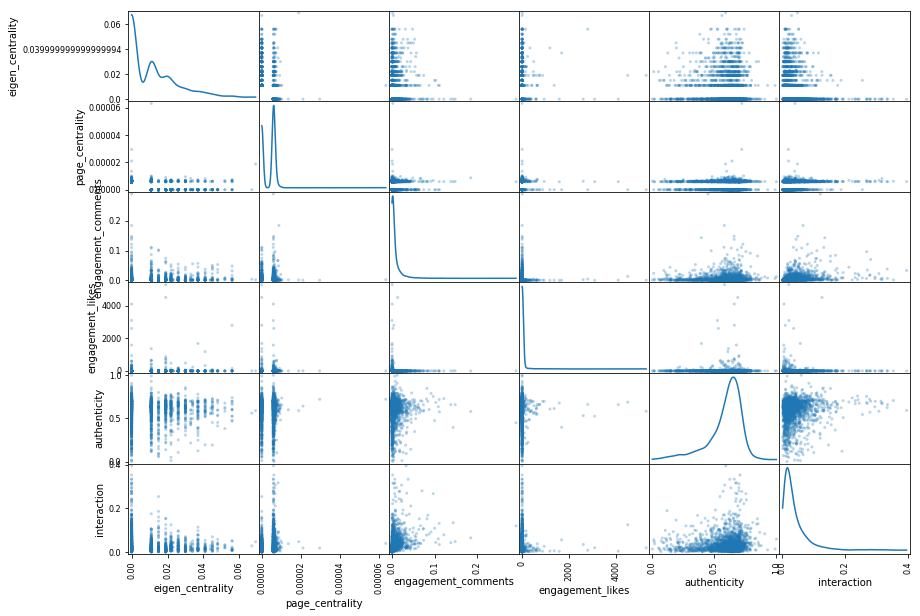

In [21]:
#Scatter matrix
import seaborn as sns

pd.scatter_matrix(metrics, alpha = 0.3, figsize = (14,10), diagonal='kde');
#sns.heatmap(metrics.corr(), cmap='BuGn')  #plus simple à implémenter
#https://medium.com/@raghavan99o/scatter-matrix-covariance-and-correlation-explained-14921741ca56

plt.show()

In [24]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

# scaling the data before PCA

data = pd.DataFrame(scale(metrics), columns=list(metrics.columns))

# implementing PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=6).fit(data)
pca_samples = pca.transform(data)

In [25]:
def pca_results(data, pca):
    
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)





In [28]:
pca_results = pca_results(data, pca)
#plt.show()

In [29]:
pca_results.cumsum()

,Explained Variance,eigen_centrality,page_centrality,engagement_comments,engagement_likes,authenticity,interaction
Dimension 1,0.2848,-0.6028,0.5951,0.2254,-0.0731,0.0953,0.4661
Dimension 2,0.4822,-0.2685,0.2598,0.9338,-0.1391,0.3415,0.9233
Dimension 3,0.6515,-0.2607,0.3021,0.7960,0.6335,0.9595,0.9409
Dimension 4,0.8124,-0.2848,0.2878,1.0368,1.2598,0.2281,1.0592
Dimension 5,0.9223,-0.3762,0.5345,1.6430,1.2897,0.3314,0.3164
Dimension 6,1.0001,0.3421,1.2205,1.5892,1.2755,0.2786,0.4040


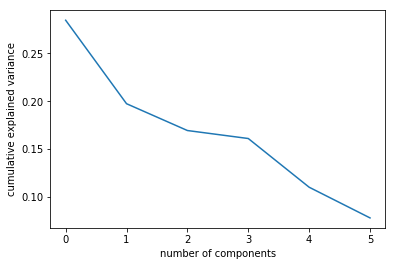

In [31]:
#Explained variance
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [43]:
# creating a biplot

pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
pca_samples = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [44]:
def biplot(data, reduced_data, pca):
    
    fig, ax = plt.subplots(figsize = (16,9))
    
    # scatterplot of the reduced data 
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 3, 2,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, data.columns[i], color='black', ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax



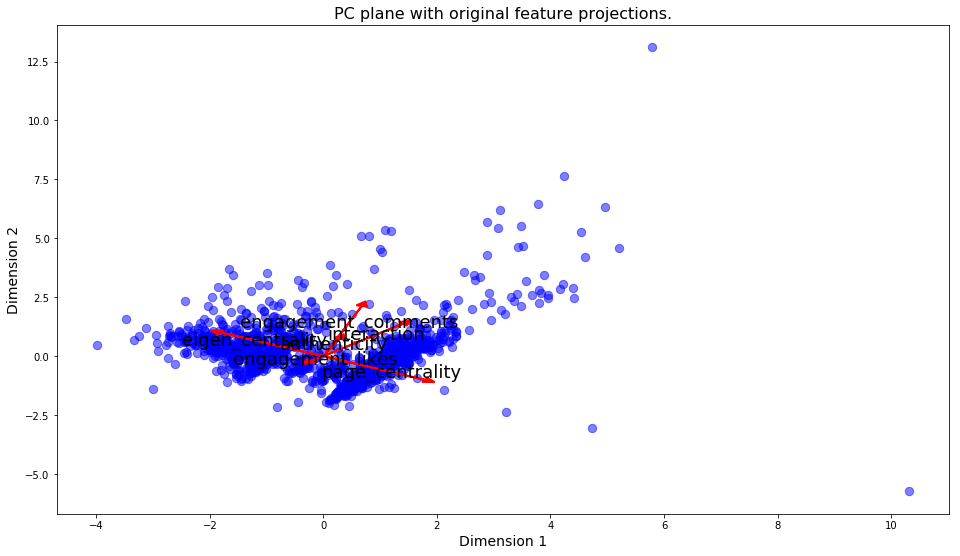

In [45]:
biplot(data, reduced_data, pca)
plt.show()

### Sélection

On va utiliser les différents critères pour sélectionner les influenceurs les plus intéressants.

#### Statistiques descriptives

Dans un premier temps, on présente quelques statistiques pour chacune de nos variables

In [3]:
from scipy import stats
import statistics as stat

def summary_statistics(table_values):
    
    values=list(table_values)
    
    #Min, max
    
    minimum=min(values)
    maximum=max(values)
    
    #Moyenne
    
    moyenne=stat.mean(values)
    
    #écart type
    
    sdev = stat.stdev(values)
    
    #Médiane et quantiles
    
    mediane=stat.median(values)
    
    output = [stats.scoreatpercentile(values, i) for i in [25,75,90,99]]
    output.append(minimum)
    output.append(maximum)
    output.append(moyenne)
    output.append(mediane)
    output.append(sdev)
    
    return output

In [7]:
quartile=[]
thridquart=[]
nineth=[]
ninetynieth=[]
minimum=[]
maximum=[]
moyenne=[]
mediane=[]
sdev=[]
variable=[]

for metric in list(metrics.columns[1:]):
    
    variable.append(metric)
    quartile.append(summary_statistics(metrics[metric])[0])
    thridquart.append(summary_statistics(metrics[metric])[1])
    nineth.append(summary_statistics(metrics[metric])[2])
    ninetynieth.append(summary_statistics(metrics[metric])[3])
    minimum.append(summary_statistics(metrics[metric])[4])
    maximum.append(summary_statistics(metrics[metric])[5])
    moyenne.append(summary_statistics(metrics[metric])[6])
    mediane.append(summary_statistics(metrics[metric])[7])
    sdev.append(summary_statistics(metrics[metric])[8])
    
    
    
statistics=pd.DataFrame()
statistics['mesure']=variable
statistics['1er quartile']=quartile
statistics['mediane']=mediane
statistics['3e quartile']=thridquart
statistics['90e percentile']=nineth
statistics['99e percentile']=ninetynieth
statistics['maximum']=maximum
statistics['moyenne']=moyenne
statistics['st_dev']=sdev

statistics.to_csv("summary_metrics.csv",header=True)

statistics

,mesure,1er quartile,mediane,3e quartile,90e percentile,99e percentile,maximum,moyenne,st_dev
0,eigen_centrality,0.000000,0.010968,0.018997,0.029965,0.047886,0.068994,0.010253,0.012775
1,page_centrality,0.000000,0.000006,0.000006,0.000006,0.000009,0.000063,0.000004,0.000003
2,engagement_comments,0.000595,0.001919,0.006717,0.017683,0.071836,0.290050,0.006944,0.015508
3,engagement_likes,0.034826,0.109084,0.311575,1.160724,585.216861,5287.895138,25.127064,232.404049
4,authenticity,0.543247,0.624137,0.677798,0.710895,0.798827,1.000000,0.589228,0.137453
5,interaction,0.012328,0.024440,0.046503,0.080886,0.235517,0.394972,0.037451,0.042252


On élimine les comptes qui sont en dessous de la médiane dans l'un des critères au moins (hormis les critères de centralité). On sélectionne ensuite les comptes de manière plus parcimonieuse

In [198]:
# Lemon dropping : on supprime les comptes qui ont une faiblesse rédhibitoire dans l'une au moins des dimensions

# Définir les quantités

med_end_com=statistics["mediane"][2]
med_eng_likes=statistics["mediane"][3]
med_auth=statistics["mediane"][4]
med_inter=statistics["mediane"][5]

#Liste à évaluer

evaluation_list=[]

for usr in users:

    if (engagement_ratio[usr][0]<med_end_com)==True:
        evaluation_list.append(usr)
    elif (engagement_ratio[usr][1]<med_eng_likes)==True:
        evaluation_list.append(usr)
    elif (authenticity_score[usr]<med_auth)==True:
        evaluation_list.append(usr)
    elif (interaction_score[usr]<med_inter)==True:
        evaluation_list.append(usr)

evaluation_list=list(dict.fromkeys(evaluation_list))

short_list0=[usr for usr in users if usr not in evaluation_list]
len(short_list0),len(users)

(196, 1948)

In [199]:
#Cherry picking : on veut des comptes qui performent dans l'une au moins des dimensions

# Définir les quantités

max_end_com=statistics['90e percentile'][2]
max_eng_likes=statistics['90e percentile'][3]
max_auth=statistics['99e percentile'][4]
max_inter=statistics["99e percentile"][5]

#Liste à évaluer

candidates=[usr for usr in short_list0]
evaluation_list=[]

for usr in candidates:

    if (engagement_ratio[usr][0]>max_end_com)==True:
        evaluation_list.append(usr)
    elif (engagement_ratio[usr][1]>max_eng_likes)==True:
        evaluation_list.append(usr)
    elif (authenticity_score[usr]>max_auth)==True:
        evaluation_list.append(usr)
    elif (interaction_score[usr]>max_inter)==True:
        evaluation_list.append(usr)
        
evaluation_list=list(dict.fromkeys(evaluation_list))

short_list=[usr for usr in users if usr in evaluation_list]
len(short_list),len(users)

(74, 1948)

In [200]:
short_list

['gaspajoe',
 'olly_lingerie',
 'naturellementgreen',
 'mllealyb',
 'happy_family_rossi',
 'lalottes',
 'ninaturelle',
 'blackwhite_loving',
 'angelique_glamconscious',
 'labauhinia',
 'gardetesconseils',
 'valentine_caporale',
 'soniaselaire',
 'bio.ralie',
 'fiona_imeneo',
 'janemichel_',
 'chaudronpastel',
 'harmonylu_',
 'bordel.de.meres',
 'sweet_celiine',
 'poussepousseoff',
 'lescookines',
 'mafrenchbox',
 'mademoisellelit',
 'taspensea',
 'madame.zero',
 'lecorpslamaisonlesprit',
 'dearlobbies',
 'agathe.the.book',
 'healthy.stud',
 'parentsprofs',
 'phrasesassassines',
 'melogommette',
 'melanie.leculdepoule',
 'b_belly18',
 'asundaymorningperrine',
 'atelierdetendances',
 'mariesavartillustrations',
 'touchworkout',
 'sodeco_off',
 'lesfrancaissontgates',
 'lilisohn',
 'daisy.dessine',
 'unesourisetdeslivres',
 'aromatips.be',
 'lulumineuse_belight',
 'la_pagaille_de_lulu_',
 'thedailyparis',
 '0paline',
 'sndfilms',
 'blogdechataigne',
 'chooavignon',
 'healthycooklife',
 'a

In [202]:
m = open('shortlist_influenceurs.txt','w')

for usr in short_list:
    m.write(str(usr)+'\t')

Utilisateurs intéressants : friendly_beauty, healthylifemary, chloeandyou, naturellementgreen, pretemoitaveste, mathilde_mu,paulineajung labelleboucle, marieandmood, tribulationsdanais, thebabooshka